# Assessment 3: RNNs for stock price prediction

In [2]:
import sys, site
from pathlib import Path

################################# NOTE #################################
#  Please be aware that if colab installs the latest numpy and pyqlib  #
#  in this cell, users should RESTART the runtime in order to run the  #
#  following cells successfully.                                       #
########################################################################

try:
    import qlib
except ImportError:
    # install qlib
    ! pip install --upgrade numpy
    ! pip install pyqlib
    if "google.colab" in sys.modules:
        # The Google colab environment is a little outdated. We have to downgrade the pyyaml to make it compatible with other packages
        ! pip install pyyaml==5.4.1
    # reload
    site.main()

scripts_dir = Path.cwd().parent.joinpath("scripts")
if not scripts_dir.joinpath("get_data.py").exists():
    # download get_data.py script
    scripts_dir = Path("~/tmp/qlib_code/scripts").expanduser().resolve()
    scripts_dir.mkdir(parents=True, exist_ok=True)
    import requests

    with requests.get("https://raw.githubusercontent.com/microsoft/qlib/main/scripts/get_data.py", timeout=10) as resp:
        with open(scripts_dir.joinpath("get_data.py"), "wb") as fp:
            fp.write(resp.content)

In [60]:
## Dataset
import qlib
from qlib.constant import REG_US
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
## Data manioulation
import pandas as pd
import numpy as np
import datetime as dt
## visualization
import plotly
import matplotlib.pyplot as plt
import seaborn as sns

## pytorch part
import torch
## pytorch: dataset
import torchvision
from torchvision import models
## pytorch: network and function
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


from torchsummary import summary

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [4]:
# setting device on GPU if available, else CPU
torch.cuda.empty_cache()
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()


#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')


Using device: cpu



## Step01: Data exploration

In [5]:
# use default data
# NOTE: need to download data from remote: python scripts/get_data.py qlib_data_cn --target_dir ~/.qlib/qlib_data/cn_data
# from qlib.config import REG_US
provider_uri = "~/.qlib/qlib_data/us_data"  # target_dir
if not exists_qlib_data(provider_uri):
    print(f"Qlib data is not found in {provider_uri}")
    sys.path.append(str(scripts_dir))
    from get_data import GetData

    GetData().qlib_data(target_dir=provider_uri, region=REG_US)
qlib.init(provider_uri=provider_uri, region=REG_US)

[17592:MainThread](2023-11-15 13:23:22,372) INFO - qlib.Initialization - [config.py:416] - default_conf: client.
[17592:MainThread](2023-11-15 13:23:22,372) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[17592:MainThread](2023-11-15 13:23:22,372) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/possa/.qlib/qlib_data/us_data')}


In [6]:
from qlib.data import D
# parameter selection
# index_list  = ['^GSPC','^IXIC','^DJI']
# index_list  = ['AAPL', 'MSFT']
# index_name  = ['Apple', 'Microsoft']
# index_list  = ['AAPL']
# index_name  = ['Apple']
# fields = ['$close', '$volume', '$open', '$high', '$low']

# df = D.features(D.instruments("all"), ["$close"], freq="day")
# inst = D.list_instruments(D.instruments(symbols ), freq="day", as_list=True) # show the selecting symbols 

# Fetch daily data for the indices
def set_df():
    # select the index & Fleids
    index_list  = ['AAPL']
    # index_list  = ['AAPL', 'MSFT']
    fields = ['$close', '$volume', '$open', '$high', '$low']
    
    # download dataset
    df = D.features(index_list , fields, freq='day')
    
    # manipulated the dataset
    df = df.reset_index()
    df.columns = ['symbols','date','close','volume','open','high','low']
    df.date = df.date.dt.date
    print(f"Period since {min(df.date)} to {max(df.date)}: {max(df.date) - min(df.date)}")
    return df, index_list

df, index_list = set_df()

Period since 1999-12-31 to 2020-11-10: 7620 days, 0:00:00


In [7]:
df.tail(5)

,symbols,date,close,volume,open,high,low
5245,AAPL,2020-11-04,146.096085,108765200.0,145.066620,146.909500,142.791611
5246,AAPL,2020-11-05,151.281586,99442752.0,149.908951,152.031448,148.536331
5247,AAPL,2020-11-06,151.109711,89901624.0,150.638641,151.759003,147.850449
5248,AAPL,2020-11-09,148.092346,121364944.0,153.414108,155.311081,147.748611
5249,AAPL,2020-11-10,147.646759,108411280.0,147.112030,149.709244,145.304153


### Exploratory Image analysis

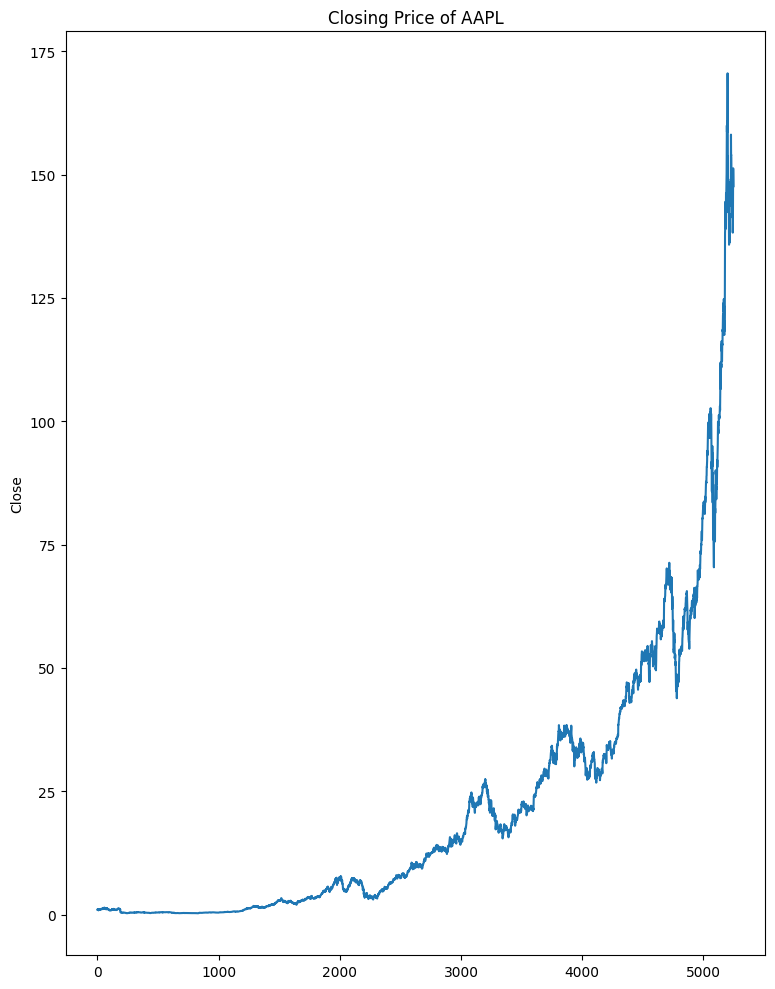

In [8]:
def plot_timeline(df):
# Let's see a historical view of the closing price
    plt.figure(figsize=(15, 10))
    plt.subplots_adjust(top=1.25, bottom=1.2)

    for i, company in enumerate(index_list, 1):
        plt.subplot(1, 2, i)
        df.loc[df['symbols'] == index_list[i-1]]['close'].plot()
        plt.ylabel('Close')
        plt.xlabel(None)
        plt.title(f"Closing Price of {index_list[i - 1]}")
        
    plt.tight_layout()
    
plot_timeline(df)

## Step 2: Data Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

df_scaled = df['close'].values
df_scaled = scaler.fit_transform(df_scaled.reshape(-1,1))
df_scaled

array([[0.00437381],
       [0.00489503],
       [0.00435596],
       ...,
       [0.88591343],
       [0.86819357],
       [0.8655768 ]], dtype=float32)

## Step 03: Data splitting

In [25]:
# splitting criteria training 70%, validation 20% and testing 10%
train_size = int(len(df_scaled) * 0.7)
valid_size = int(len(df_scaled) * 0.2)

train_data = df_scaled[:train_size]
valid_data = df_scaled[train_size:train_size + valid_size]
test_data = df_scaled[train_size + valid_size:]

print(f"Training size: {len(train_data)} period {df.date[0]} to {df.date[train_size-1]} \nValidation size: {len(valid_data)} period {df.date[train_size]} to {df.date[train_size + valid_size-1]}\ntest_data size: {len(test_data)} period {df.date[train_size + valid_size]} to {df.date[len(df_scaled)-1]}")

Training size: 3674 period 1999-12-31 to 2014-08-08 
Validation size: 1050 period 2014-08-11 to 2018-10-09
test_data size: 526 period 2018-10-10 to 2020-11-10


In [76]:
def create_dataset(dataset,time_step):
    X,y = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:i+time_step,0]
        X.append(a)
        y.append(dataset[i+time_step,0])
        
    # #RNN and LSTM takes 3D inputs, we need to change the shape of array to 3 dimensional.
    X_output = torch.tensor(np.array(X))
    # X_output = X_output.reshape(X_output.shape[0],X_output.shape[1],1)
    Y_output = torch.tensor(np.array(y)).unsqueeze(dim=1)
    return X_output,Y_output

X_train , y_train = create_dataset(train_data,50)
X_train.shape

torch.Size([3623, 50])

## Step 04: Define the RNN Model

In [77]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()

        self.RNN = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state):
        r_out, hidden_state = self.RNN(x, h_state)
        
        hidden_size = hidden_state[-1].size(-1)
        r_out = r_out.view(-1, hidden_size)
        outs = self.out(r_out)

        return outs, hidden_state
    
# RNN Module
rnn = RNN(input_size = 1, hidden_size = 32, num_layers = 2,  output_size = 1)
rnn

RNN(
  (RNN): RNN(1, 32, num_layers=2)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [79]:
from tqdm import tqdm
import torch.autograd
torch.autograd.set_detect_anomaly(True)

optimiser = torch.optim.Adam(rnn.parameters(), lr=0.01)
criterion = nn.MSELoss()
trainloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train, y_train), 
    shuffle=True, 
    batch_size=8
    )

hidden_state = None

for epoch in range(100):
    inputs, labels = inputs.to(device), labels.to(device)

    output, hidden_state = rnn(inputs, hidden_state) 

    loss = criterion(output.view(-1).clone(), labels)
    optimiser.zero_grad()
    loss.backward(retain_graph=True)                     # back propagation
    optimiser.step()                                     # update the parameters
    
    print('epoch {}, loss {}'.format(epoch,loss.item()))

c:\Users\possa\.conda\envs\Deep_learning\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([400, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (400) must match the size of tensor b (8) at non-singleton dimension 0

In [128]:
import torch
import torch.nn as nn

class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(StockRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model = StockRNN(input_size=5, hidden_size=10, num_layers=2)

## Step 05: training model

In [14]:
def train_epoch(model, trainloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(trainloader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct_train += torch.sum(preds == labels.data)
        total_train += labels.size(0)

    epoch_loss = running_loss / total_train
    epoch_acc = correct_train.double() / total_train
    return epoch_loss, epoch_acc

In [121]:
criterion = nn.MSELoss()
num_epochs = 10
print_every = 1
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)

train(rnn, num_epochs, print_every)

TypeError: forward() takes 2 positional arguments but 3 were given

In [ ]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.1
model = NaturalSceneClassification()
#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, trainloader, testloader, opt_func)

In [ ]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

### 6. Evaluation with Testing Set